<a href="https://colab.research.google.com/github/TonyQ2k3/pytorch-training/blob/main/notebooks/pytorch_day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Day 4
---

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

## Machine Learning Classification

### Binary vs Multi-class

**Binary classification**
+ Involves classification between 2 classes: Yes/No or Positive/Negative
+ Used in single object detection, ie. Spam/Not Spam, Cancer/Not Cancer

**Multi-class classification**
+ More than 2 classes, represented by integers starting from 0.
+ Output is a vector of probabilities for each class, with the sum of the vector being 1 (100%).

### Inputs and Outputs

**Input**
+ Data represented as a multi-dimension tensor.
+ For image classification, input will be a tensor of shape 224 x 224 x 3.

**Output**
+ A list of bounding boxes, each box is a tuple of `(x_coord, y_coord, width, height, confidence)` representing the coordinate, size and confidence of detected class.

### Architecture of Classification Neural Network

**Binary Classification**
1. Input layer's shape: == number of features
2. Output layer's shape: *1*
3. Hidden layers: 1 - unlimited
4. Neurons per hidden layer: 10-512
5. Hidden layer activation: ReLU
6. Output layer activation: Sigmoid
7. Loss function: *Binary Cross-entropy (BCE)*
8. Optimizer: SGD, Adam

**Multi-class**
1. Input layer's shape: == number of features
2. Output layer's shape: *== number of classes*
3. Hidden layers: 1 - unlimited
4. Neuron per layers: 10-512
5. Hidden layer activation: ReLU
6. Output layer activation: *SoftMax*
6. Loss function: *Cross-entropy*
7. Optimizer: SGD, Adam

## Building a classifiction model

### Prepare classification data

In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
# Make 1000 samples
n_samples = 1000
x, y = make_circles(n_samples, noise=0.03, random_state=42)
print(x.shape)
print(y.shape)

(1000, 2)
(1000,)


In [4]:
# Make dataframe based on circles
circles = pd.DataFrame({
    "x1": x[:, 0],
    "x2": x[:, 1],
    "label": y
})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


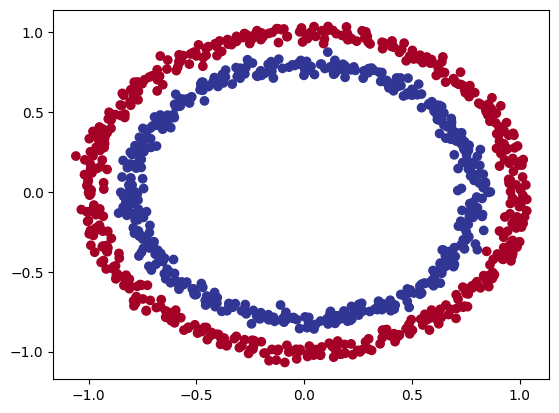

In [5]:
# Visualize the circles
def plot_circles(x, y):
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu)
    plt.show()

plot_circles(x, y)

In [6]:
# Convert to tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(x[:5])
print(y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
tensor([1., 1., 1., 1., 0.])


In [7]:
# Splitting data randomly
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2])
torch.Size([800]) torch.Size([200])


### Build ML model

In [8]:
import torch
from torch import nn

#### Subclassing `nn.Module`

In [9]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)


  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [10]:
# Put the model on GPU (CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
circle_model = CircleModelv1().to(device)

#### Using `nn.Sequential()`

In [44]:
circle_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [ ]:
print(f"Circle model params: {circle_model.state_dict()}")

In [13]:
# Untrained predictions
with torch.inference_mode():
  untrained_preds = torch.round(circle_model(x_test.to(device))).squeeze()
print(untrained_preds[:5])

tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [46]:
# Setup loss func, optimizer and epoch
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=circle_model.parameters(), lr=0.01)
activation_fn = nn.Sigmoid()
epochs = 1000

In [15]:
def accuracy_function(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### Train the model

In [31]:
def train_model(model, train_losses, test_losses):
  for epoch in range(epochs):
    ### Training
    model.train()

    y_logits = model(x_train).squeeze()
    y_pred = torch.round(activation_fn(y_logits))
    train_acc = accuracy_function(y_train, y_pred)

    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      test_logits = model(x_test).squeeze()
      test_pred = torch.round(activation_fn(test_logits))
      test_acc = accuracy_function(y_test, test_pred)

      test_loss = loss_fn(test_logits, y_test)
      test_losses.append(test_loss.item())

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.3f} | Train Acc: {train_acc:.5f} | Test Loss: {test_acc:.3f}")



In [23]:
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [52]:
train_l = []
test_l = []
train_model(circle_model, train_l, test_l) # It's not learning!

Epoch: 0 | Train Loss: 0.69671 | Test Loss: 0.693 | Train Acc: 49.87500 | Test Loss: 49.500
Epoch: 100 | Train Loss: 0.69623 | Test Loss: 0.693 | Train Acc: 49.87500 | Test Loss: 50.000
Epoch: 200 | Train Loss: 0.69583 | Test Loss: 0.692 | Train Acc: 50.00000 | Test Loss: 50.000
Epoch: 300 | Train Loss: 0.69549 | Test Loss: 0.692 | Train Acc: 50.00000 | Test Loss: 50.000
Epoch: 400 | Train Loss: 0.69520 | Test Loss: 0.692 | Train Acc: 50.00000 | Test Loss: 50.500
Epoch: 500 | Train Loss: 0.69495 | Test Loss: 0.692 | Train Acc: 49.87500 | Test Loss: 50.500
Epoch: 600 | Train Loss: 0.69473 | Test Loss: 0.692 | Train Acc: 49.87500 | Test Loss: 50.500
Epoch: 700 | Train Loss: 0.69455 | Test Loss: 0.692 | Train Acc: 49.87500 | Test Loss: 50.500
Epoch: 800 | Train Loss: 0.69438 | Test Loss: 0.692 | Train Acc: 49.75000 | Test Loss: 50.500
Epoch: 900 | Train Loss: 0.69424 | Test Loss: 0.692 | Train Acc: 49.87500 | Test Loss: 50.500


In [41]:
epoch_list = [x for x in range(epochs)]

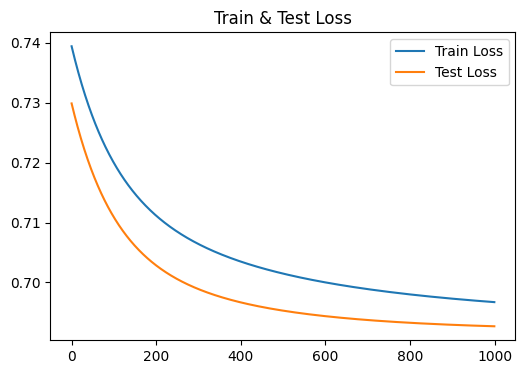

In [51]:
# Visualize train and test loss
def loss_visualize(train_losses, test_losses):
  plt.figure(figsize=(6,4))
  plt.title("Train & Test Loss")
  plt.plot(epoch_list, train_losses, label="Train Loss")
  plt.plot(epoch_list, test_losses, label="Test Loss")
  plt.legend()
  plt.show()

loss_visualize(train_l, test_l)

#### Extras: helper function

In [60]:
# Download helper function
import requests
from pathlib import Path

if Path("helper_functions.py").is_file() is not True:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


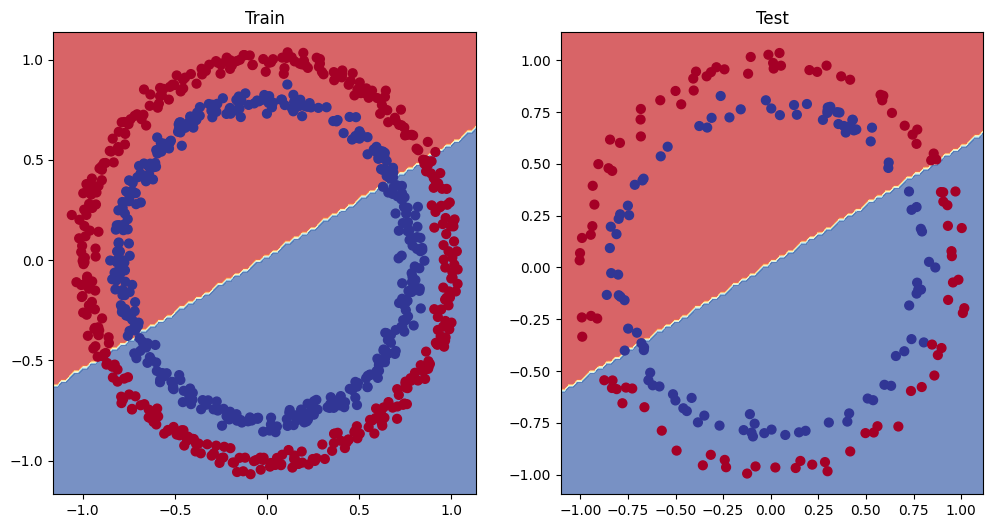

In [66]:
# Visualize result
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model, x_test, y_test)

### Improve the model

Several ways to improve a model are:
1. Increase the number of layers
2. Add more neurons per layer
3. Change activation function, loss function or optimizer
4. Change learning rate / momentum